# Agents:
These simulations evaluate several agents exploring the thread the needle enviroment

In [38]:
%load_ext autoreload
%autoreload 2
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
%matplotlib inline
import sys
import torch
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DQN, PPO
import matplotlib.pyplot as plt

from state_inference.gridworld_env import CnnWrapper, OpenEnv, ThreadTheNeedleEnv
from state_inference.utils.training_utils import train_model, parse_config
from state_inference.utils.pytorch_utils import DEVICE
from state_inference.model.baseline_compatible import ValueIterationAgent, ViAgentWithExploration

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")


python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
torch 2.0.1
device = mps


In [40]:
CONFIG_FILE = "state_inference/env_config.yml"
TASK_NAME = "thread_the_needle"
TASK_CLASS = ThreadTheNeedleEnv

In [41]:
env_kwargs, training_kwargs = parse_config(TASK_NAME, CONFIG_FILE)

training_kwargs["n_train_steps"] = 50000
training_kwargs["n_epochs"] = 1

# create the task
task = CnnWrapper(TASK_CLASS.create_env(**env_kwargs))

pi, _ = task.get_optimal_policy()
training_kwargs["optimal_policy"] = pi

  0%|          | 0/1000 [00:00<?, ?it/s]

In [42]:
from state_inference.model.vae import DEVICE, Encoder, Decoder, StateVae

### Model + Training Parameters
N_EPOCHS = 20  # should be 20
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(task.observation_model.states) // 2
OBSERVATION_DIM = task.observation_model.map_height**2
LR = 3e-4
beta = 1.0
tau = 2.0
gamma = 0.99
dropout = 0.0

optim_kwargs = dict(lr=LR)

# create the model
encoder_hidden = [OBSERVATION_DIM // 5, OBSERVATION_DIM // 10]
decoder_hidden = [OBSERVATION_DIM // 10, OBSERVATION_DIM // 5]
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS

encoder = Encoder(
    OBSERVATION_DIM,
    encoder_hidden,
    z_dim,
    dropout=dropout,
)

decoder = Decoder(
    z_dim,
    decoder_hidden,
    OBSERVATION_DIM,
    dropout=dropout,
)

vae_kwargs = dict(
    z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS, beta=beta, tau=tau, gamma=gamma
)

vae_model = StateVae(encoder, decoder, **vae_kwargs).to(DEVICE)
print(vae_model)

agent = ViAgentWithExploration(
    task, vae_model, set_action=set(range(4)), optim_kwargs=optim_kwargs
)

StateVae(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=1600, out_features=320, bias=True)
      (1): BatchNorm1d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=320, out_features=160, bias=True)
      (5): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Dropout(p=0.0, inplace=False)
      (7): ReLU()
      (8): Linear(in_features=160, out_features=1000, bias=True)
      (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=1000, out_features=160, bias=True)
      (1): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): Dropout(p=0.0, inplace=False)
      (3): ReLU()
      (4): Linear(in_features=160, out_features=320, bias=True)
      (5): BatchNorm1

In [43]:
agent.learn(20000)

In [44]:
len(agent.cached_obs)

20001

In [45]:
len(agent.cached_oaro_tuples)

20000

In [46]:
from state_inference.utils.training_utils import get_policy_prob

pmf = get_policy_prob(
    agent,
    n_states=env_kwargs["n_states"],
    map_height=env_kwargs["map_height"],
    cnn=True,
)
pmf

/Users/nicholasfranklin/Projects/StateInference/state_inference/utils/pytorch_utils.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=float)


array([[0.00580125, 0.58213634, 0.00580125, 0.40626115],
       [0.00837349, 0.112682  , 0.00184534, 0.87709916],
       [0.00837349, 0.112682  , 0.00184534, 0.87709916],
       ...,
       [0.62323524, 0.01659934, 0.34356609, 0.01659934],
       [0.62323524, 0.01659934, 0.34356609, 0.01659934],
       [0.62323524, 0.01659934, 0.34356609, 0.01659934]])

Text(0.5, 0.98, 'Value Iteration Agent Learned Policy')

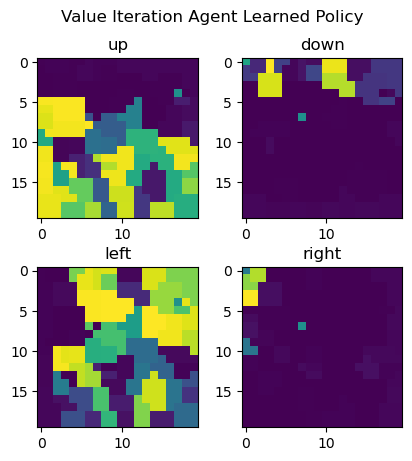

In [47]:
import seaborn as sns

fig, axes = plt.subplots(2, 2)
h, w = env_kwargs["height"], env_kwargs["width"]

axes[0][0].imshow(pmf[:, 0].reshape(h, w))
axes[0][1].imshow(pmf[:, 1].reshape(h, w))
axes[1][0].imshow(pmf[:, 2].reshape(h, w))
axes[1][1].imshow(pmf[:, 3].reshape(h, w))


axes[0][0].set_title("up")
axes[0][1].set_title("down")
axes[1][0].set_title("left")
axes[1][1].set_title("right")

plt.subplots_adjust(hspace=0.3, wspace=-0.3)

plt.suptitle("Value Iteration Agent Learned Policy")

In [48]:
agent.value_function

{16774932858: 388.9675839709292,
 51603052909: 384.977708429802,
 102904038628: 397.89705574324495,
 52771813179: 381.0277316440861,
 51603072709: 381.0668403251328,
 316771813179: 376.0305175075055,
 47373006061: 403.15905074014006,
 158885386110: 389.5222902303149,
 176845965333: 395.6467049059232,
 104790433117: 424.7529425456103,
 101418835618: 408.49230316883023,
 237478779161: 412.61958622147347,
 157681819377: 389.8165031180359,
 79962712686: 387.19076501562824,
 209507158240: 455.1349313321741,
 289776623895: 455.4982732575064,
 173504925774: 450.8430908235134,
 212375938172: 463.9590080539025,
 109998542585: 466.9864034701455,
 233343339448: 462.1595940478166,
 71200521027: 457.0634486467676,
 182240673565: 452.6301372550579,
 180596085425: 448.0036361810895,
 190590087273: 438.6275132266806,
 154393562214: 446.39748148892227,
 310563194634: 437.51592628502675,
 34566302692: 454.16909177642924,
 238320182692: 449.5272011572471,
 35120182692: 449.5272011572471,
 57324461497: 45

In [49]:
np.sum(pi * pmf, axis=1).mean()

0.6867864874402201

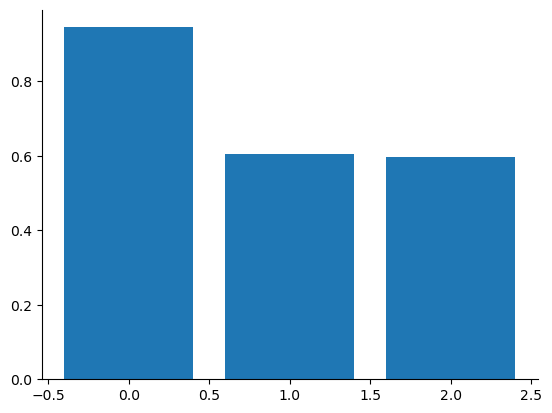

In [50]:
room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10

score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()
plt.bar([0, 1, 2], [score_room_1, score_room_2, score_room_3])

sns.despine()

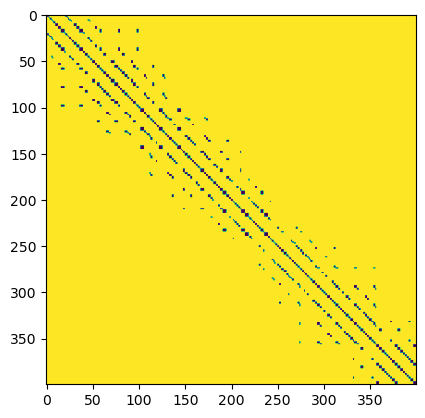

In [51]:
from state_inference.utils.pytorch_utils import make_tensor, convert_8bit_to_float
from sklearn.metrics import pairwise_distances

obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)
d = pairwise_distances(z.reshape(-1, 1), metric=lambda x, y: x == y)
plt.imshow(1 - d)

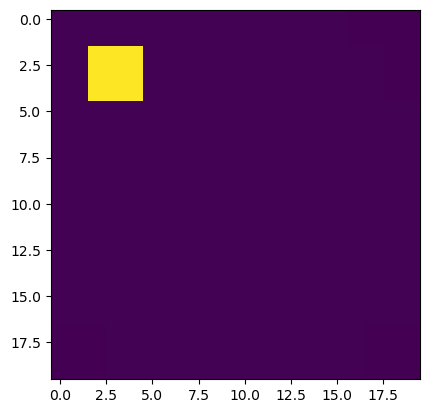

In [52]:
# agent._estimate_reward_model()

rews = np.array([agent.reward_estimator.get_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

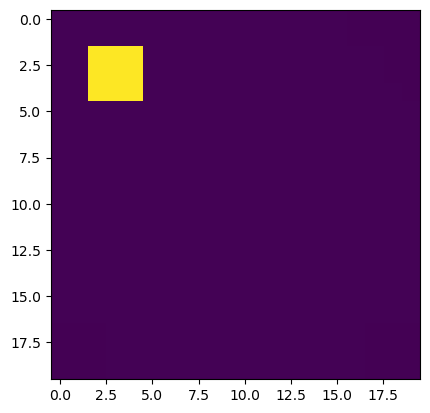

In [53]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.reward_estimator.get_reward(z0) for z0 in z]).reshape(20, 20)
plt.imshow(rews)

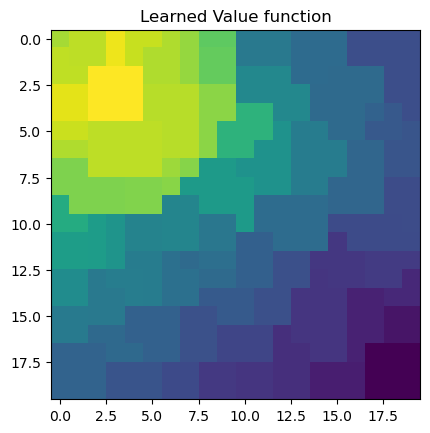

In [54]:
obs = convert_8bit_to_float(
    torch.stack(
        [
            make_tensor(task.observation_model(s))
            for s in range(task.transition_model.n_states)
            for _ in range(1)
        ]
    )
).to(DEVICE)
z = agent.state_inference_model.get_state(obs)

hash_vector = np.array(
    [
        agent.state_inference_model.z_dim**ii
        for ii in range(agent.state_inference_model.z_layers)
    ]
)

z = z.dot(hash_vector)

rews = np.array([agent.value_function.get(z0, np.nan) for z0 in z]).reshape(20, 20)
plt.title("Learned Value function")
plt.imshow(rews)

In [56]:
from tqdm import trange

## Repeat with iterations
n_models = 15


room_1_mask = (np.arange(400) < 200) * (np.arange(400) % 20 < 10)
room_2_mask = (np.arange(400) >= 200) * (np.arange(400) % 20 < 10)
room_3_mask = np.arange(400) % 20 >= 10


scores = []


for idx in trange(n_models):
    agent = ViAgentWithExploration(
        task, vae_model, set_action=set(range(4)), optim_kwargs=optim_kwargs
    )
    agent.learn(total_timesteps=training_kwargs["n_train_steps"], progress_bar=False)
    # agent.learn(total_timesteps=500, progress_bar=False)

    pmf = get_policy_prob(
        agent,
        n_states=env_kwargs["n_states"],
        map_height=env_kwargs["map_height"],
        cnn=True,
    )

    score_room_1 = np.sum(pi[room_1_mask] * pmf[room_1_mask], axis=1).mean()
    score_room_2 = np.sum(pi[room_2_mask] * pmf[room_2_mask], axis=1).mean()
    score_room_3 = np.sum(pi[room_3_mask] * pmf[room_3_mask], axis=1).mean()

    scores.append(
        pd.DataFrame(
            {
                "Iteration": [idx] * 4,
                "Score": [
                    np.sum(pi * pmf, axis=1).mean(),
                    score_room_1,
                    score_room_2,
                    score_room_3,
                ],
                "Condition": ["Overall", "Room 1", "Room 2", "Room 3"],
            }
        )
    )

scores = pd.concat(scores)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/nicholasfranklin/Projects/StateInference/state_inference/utils/pytorch_utils.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=float)
 10%|█         | 1/10 [13:41<2:03:12, 821.38s/it]

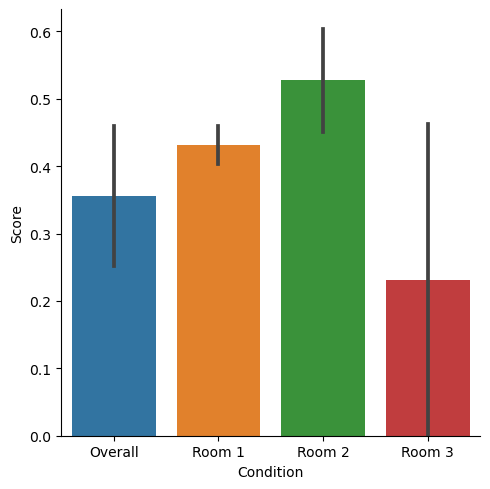

In [ ]:
sns.catplot(data=scores, y="Score", x="Condition", kind="bar")

In [ ]:
scores["Model"] = "Value Iteration"
scores.to_csv("sims_thread_the_needle_vi_agent.csv")
scores2 = pd.read_csv("sims_thread_the_needle.csv")
scores2["Model"] = "PPO"


all_scores = pd.concat([scores, scores2])
sns.catplot(
    data=all_scores[all_scores["Condition"] != "Overall"],
    y="Score",
    x="Condition",
    kind="point",
    hue="Model",
)
plt.gca().set_ylim([0, 1])